# GFDL AM4 Green's functions
- adapted from Bosong Zhang notebook
- Vince Cooper: added conservative regridding to save final green's functions on the 96x144 lat-lon grid used in other Green's functions

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.patches as mpatches
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import copy

In [2]:
# reading lat lon infomation
ds_land = xr.open_dataset('atmos.static.nc')
land = ds_land['land_mask']
# print(land.shape)
lat = ds_land['lat']
lon = ds_land['lon']
is_ocean = ds_land['land_mask'] < 0.1

In [3]:
grid_am4 = ds_land.drop(['bk','pk','phalf'])

In [20]:
## NOTE: need to run each of these variables separately

varname  = 'R'
# varname  = 'R_cre'
# varname  = 'T'

path1    = 'low_reso_A4p0/'
files1   = [f'{path1}pvalue_1.00/matrixa.{varname}_i_times_npatch_{month:02d}.nc'
         for month in range(1, 13)]
files2   = [f'{path1}matrixb_npatch_times_j_{month:02d}.nc'
         for month in range(1, 13)]

dsa = xr.open_mfdataset(files1, parallel=True, combine='nested',concat_dim=['month'])
dsb = xr.open_mfdataset(files2, parallel=True, combine='nested',concat_dim=['month'])

In [21]:
%%time
# dsa
jaco = np.empty((12,12960,12960))
for i in range(0,12):
    jaco[i,:,:] = np.matmul(dsa['dvar_dsst_p'][i,:,:].values,\
                            dsb['dsst_j_times_a_j_over_a_p_over_sig_dsst_j'][i,:,:].values)


CPU times: user 24.5 s, sys: 10.8 s, total: 35.3 s
Wall time: 8.16 s


In [22]:
jaco_mean = np.mean(jaco,axis=0)

In [23]:
%%time
jaco1_reshape = xr.DataArray(
    np.reshape(jaco_mean,(90,144,12960)),
    dims=["lat", "lon", "jj"],
    coords=dict(
        lon=lon,
        lat=lat,
    ),
)

weights = np.cos(np.deg2rad(lat))
jaco1_dm = jaco1_reshape.weighted(weights).mean(("lon", "lat")).astype(np.float32)
jaco1_map = xr.DataArray(
    np.reshape(np.array(jaco1_dm),(90,144)),
    dims=["lat", "lon"],
    coords=dict(
        lon=lon,
        lat=lat,
    ),
)
jaco1_map_mask = jaco1_map.where(is_ocean)

CPU times: user 1.01 s, sys: 434 ms, total: 1.45 s
Wall time: 1.45 s


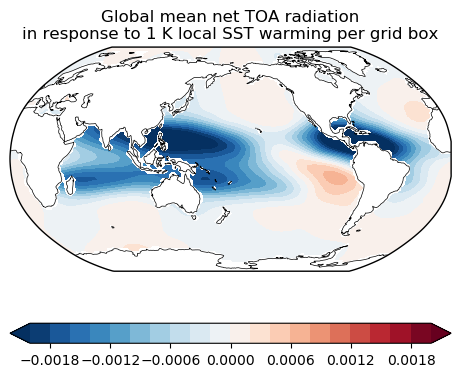

In [19]:
if varname == 'R':
    my_size  = 15
    fig  = plt.figure(figsize=(5,4),dpi=100)
    # cmap = plt.colormaps['RdBu_r']
    cmap = 'RdBu_r'
    clevels = np.arange(-2.0,2.2,0.2)/1e3
    # print(clevels)

    ax1 = plt.subplot(1,1,1,projection=ccrs.Robinson(central_longitude=180))
    sp1 = ax1.contourf(lon, lat, jaco1_map_mask, levels=clevels,cmap=cmap,extend='both',transform=ccrs.PlateCarree())
    ax1.coastlines(linewidth=0.5)

    # ax1.set_title('AM4',size = my_size)
    cbar = plt.colorbar(sp1,ax=ax1,orientation='horizontal')
    plt.title('Global mean net TOA radiation\n'+
                 'in response to 1 K local SST warming per grid box'
                 ,fontsize=12,horizontalalignment='center')
    plt.tight_layout()

    jaco1_map_mask_R = copy.deepcopy(jaco1_map_mask)

[-2.0000000e-03 -1.8000000e-03 -1.6000000e-03 -1.4000000e-03
 -1.2000000e-03 -1.0000000e-03 -8.0000000e-04 -6.0000000e-04
 -4.0000000e-04 -2.0000000e-04 -4.4408921e-19  2.0000000e-04
  4.0000000e-04  6.0000000e-04  8.0000000e-04  1.0000000e-03
  1.2000000e-03  1.4000000e-03  1.6000000e-03  1.8000000e-03
  2.0000000e-03]


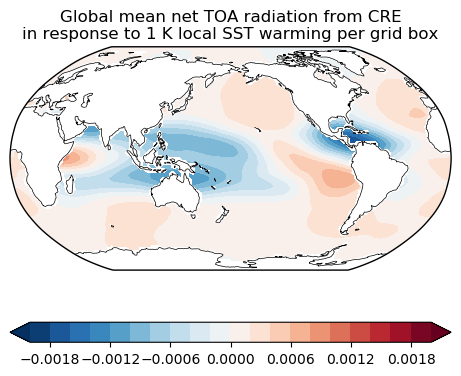

In [14]:
if varname == 'R_cre':
    my_size  = 15
    fig  = plt.figure(figsize=(5,4),dpi=100)
    # cmap = plt.colormaps['RdBu_r']
    cmap = 'RdBu_r'
    clevels = np.arange(-2.0,2.2,0.2)/1e3
    print(clevels)

    ax1 = plt.subplot(1,1,1,projection=ccrs.Robinson(central_longitude=180))
    sp1 = ax1.contourf(lon, lat, jaco1_map_mask, levels=clevels,cmap=cmap,extend='both',transform=ccrs.PlateCarree())
    ax1.coastlines(linewidth=0.5)

#     plt.title('AM4',size = my_size)
    cbar = plt.colorbar(sp1,ax=ax1,orientation='horizontal')
    plt.title('Global mean net TOA radiation from CRE\n'+
                 'in response to 1 K local SST warming per grid box'
                 ,fontsize=12,horizontalalignment='center')
    plt.tight_layout()
    
    jaco1_map_mask_Rcre = copy.deepcopy(jaco1_map_mask)

[-2.0000000e-03 -1.8000000e-03 -1.6000000e-03 -1.4000000e-03
 -1.2000000e-03 -1.0000000e-03 -8.0000000e-04 -6.0000000e-04
 -4.0000000e-04 -2.0000000e-04 -4.4408921e-19  2.0000000e-04
  4.0000000e-04  6.0000000e-04  8.0000000e-04  1.0000000e-03
  1.2000000e-03  1.4000000e-03  1.6000000e-03  1.8000000e-03
  2.0000000e-03]


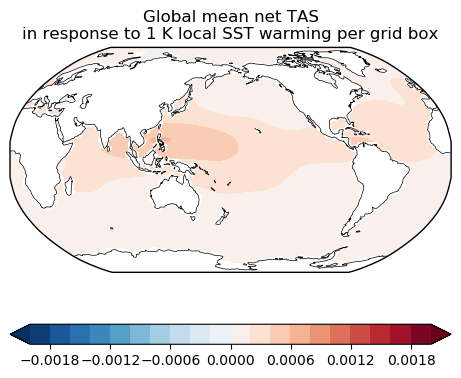

In [24]:
if varname == 'T':
    my_size  = 15
    fig  = plt.figure(figsize=(5,4),dpi=100)
    # cmap = plt.colormaps['RdBu_r']
    cmap = 'RdBu_r'
    clevels = np.arange(-2.0,2.2,0.2)/1e3
    print(clevels)

    ax1 = plt.subplot(1,1,1,projection=ccrs.Robinson(central_longitude=180))
    sp1 = ax1.contourf(lon, lat, jaco1_map_mask, levels=clevels,cmap=cmap,extend='both',transform=ccrs.PlateCarree())
    ax1.coastlines(linewidth=0.5)

#     plt.title('AM4',size = my_size)
    cbar = plt.colorbar(sp1,ax=ax1,orientation='horizontal')
    plt.title('Global mean net TAS\n'+
                 'in response to 1 K local SST warming per grid box'
                 ,fontsize=12,horizontalalignment='center')
    plt.tight_layout()
    
    jaco1_map_mask_T = copy.deepcopy(jaco1_map_mask)

# VTC additions to save output

- If you want the real values of the GF which you can multiply by dSST, then use the output provided above and saved as jaco1_map_mask
- If you want to plot the GF results faithfully, then divide 'jaco1_map_mask' by 'weights' so that the area of the grid box does not influence the result (otherwise the polar grid cells are even smaller values than they should be; beware this change is not drastic, you might not notice unless looking carefully at poles)

In [25]:
import xesmf as xe

In [26]:
green = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/plio/data/ref/CAM4-CAM5_Greens_Function.nc')
green_mz = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/plio/data/ref/Zhou_etal_2017_GreensFunction.nc')
landfrac = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/plio/data/ref/domain.lnd.fv1.9x2.5_gx1v6.090206.nc')

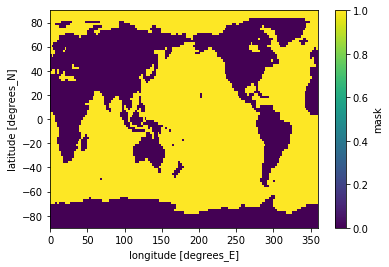

In [27]:
jaco_all = jaco1_map_mask_R.rename('TOA_AM4').to_dataset()
jaco_all['TAS_AM4'] = jaco1_map_mask_T
jaco_all['CRE_AM4'] = jaco1_map_mask_Rcre
jaco_all['mask'] = is_ocean

jaco_all['mask'].plot()
plt.show()

In [28]:
green['mask'] = xr.where(landfrac.frac.values < 0.1, 1, green.TOA_CAM5*0)

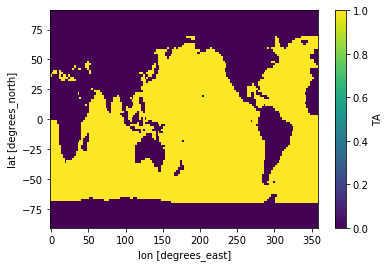

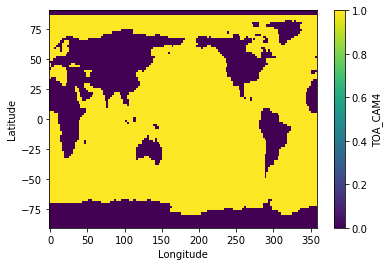

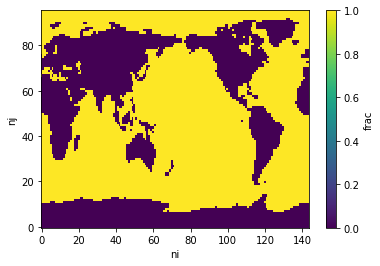

In [39]:
xr.where(green_mz.TA == 0,0,1).plot()
plt.show()

xr.where(green.TOA_CAM4 == 0,0,1).plot()
plt.show()

## I end up using this mask
xr.where(landfrac.frac > 0.2,0,1).plot()
plt.show()


In [146]:
newgrid = green_mz
# newgrid = newgrid.rename_dims({'lat':'yc','lon':'xc'})
# newgrid = newgrid.rename({'bounds_lat':'lat_b',
#                          'bounds_lon':'lon_b',})
newgrid['mask'] = xr.where(landfrac.frac.values < 0.1, 1, newgrid.TS*0)
newgrid['lat_b'] = np.unique(np.hstack([newgrid.bounds_lat[:,0],
                                        newgrid.bounds_lat[:,1]]))
newgrid['lon_b'] = np.unique(np.hstack([newgrid.bounds_lon[:,0],
                                        newgrid.bounds_lon[:,1]]))

# llon, llat = np.meshgrid(newgrid.lon, newgrid.lat)
# newgrid['lat'] = xr.where(newgrid.mask > -1, llat, llat)
# newgrid['lon'] = xr.where(newgrid.mask > -1, llon, llon)
# newgrid

<xarray.Dataset>
Dimensions:     (lat: 96, bound: 2, lon: 144, lat_b: 97, lon_b: 145)
Coordinates:
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat_b       (lat_b) float64 -90.0 -89.05 -87.16 -85.26 ... 87.16 89.05 90.0
  * lon_b       (lon_b) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bound
Data variables:
    bounds_lat  (lat, bound) float64 -90.0 -89.05 -89.05 ... 89.05 89.05 90.0
    bounds_lon  (lon, bound) float64 -1.25 1.25 1.25 3.75 ... 356.2 356.2 358.8
    TA          (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    PL          (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LR          (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    WV          (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CL          (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TS          (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.0
    history:      Written by /work/zelinka1/scripts/load_GreensFunction_mat_f...

In [144]:
data_for_regridding = grid_am4
# data_for_regridding = data_for_regridding.rename({'lat_bnds':'lat_b',
#                                                   'lon_bnds':'lon_b',})
data_for_regridding['lat_b'] = np.unique(np.hstack([data_for_regridding.lat_bnds[:,0],
                                                    data_for_regridding.lat_bnds[:,1]]))
data_for_regridding['lon_b'] = np.unique(np.hstack([data_for_regridding.lon_bnds[:,0],
                                                    data_for_regridding.lon_bnds[:,1]]))
data_for_regridding['mask'] = xr.where(is_ocean == True, 1, 0)
data_for_regridding

# data_for_regridding = data_for_regridding.rename_dims({'lat':'yc','lon':'xc'})
# llon, llat = np.meshgrid(data_for_regridding.lon, data_for_regridding.lat)
# llon
# data_for_regridding['lat'] = xr.where(data_for_regridding.mask > -1, llat, llat)
# data_for_regridding['lon'] = xr.where(data_for_regridding.mask > -1, llon, llon)

<xarray.Dataset>
Dimensions:    (lat: 90, lon: 144, bnds: 2, lat_b: 91, lon_b: 145)
Coordinates:
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat_b      (lat_b) float64 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon_b      (lon_b) float64 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
Dimensions without coordinates: bnds
Data variables:
    land_mask  (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    lat_bnds   (lat, bnds) float64 -90.0 -88.0 -88.0 -86.0 ... 88.0 88.0 90.0
    lon_bnds   (lon, bnds) float64 0.0 2.5 2.5 5.0 ... 355.0 357.5 357.5 360.0
    zsurf      (lat, lon) float32 2.75e+03 2.752e+03 2.755e+03 ... 0.0 0.0 0.0
    mask       (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1

In [147]:
newgrid = newgrid.transpose('bound',...)
data_for_regridding = data_for_regridding.transpose('bnds',...)

<xarray.Dataset>
Dimensions:    (lat: 90, lon: 144, bnds: 2, lat_b: 91, lon_b: 145)
Coordinates:
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat_b      (lat_b) float64 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon_b      (lon_b) float64 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
Dimensions without coordinates: bnds
Data variables:
    land_mask  (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    lat_bnds   (bnds, lat) float64 -90.0 -88.0 -86.0 -84.0 ... 86.0 88.0 90.0
    lon_bnds   (bnds, lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5 360.0
    zsurf      (lat, lon) float32 2.75e+03 2.752e+03 2.755e+03 ... 0.0 0.0 0.0
    mask       (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1

In [135]:
## note for future: can use this to make grids
# xe.util.grid_global(2.5,1.89).lat_b[:,0]

In [161]:
## Note: 'conservative' preserves integral better but looks wrong with a mask
##       'conservative_normed' looks right but slightly gets different values
regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='conservative_normed',
                         periodic=True,
#                          extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         reuse_weights=False)

In [163]:
## do the regridding
jaco_all_gridfix = regridder(jaco_all)

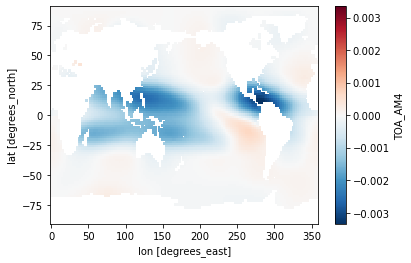

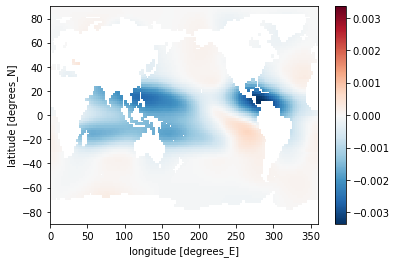

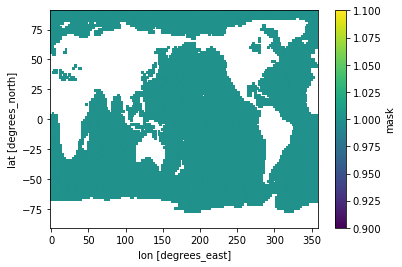

In [167]:
jaco_all_gridfix['TOA_AM4'].plot()
plt.show()

jaco1_map_mask_R.plot()
plt.show()

jaco_all_gridfix['mask'].plot()
plt.show()

In [165]:
print(jaco_all_gridfix['TOA_AM4'].sum())
print(jaco_all['TOA_AM4'].sum())


print(jaco_all_gridfix['TAS_AM4'].sum())
print(jaco_all['TAS_AM4'].sum())

<xarray.DataArray 'TOA_AM4' ()>
array(-2.82902673)
<xarray.DataArray 'TOA_AM4' ()>
array(-2.636858, dtype=float32)
<xarray.DataArray 'TAS_AM4' ()>
array(1.30962388)
<xarray.DataArray 'TAS_AM4' ()>
array(1.2253007, dtype=float32)


In [166]:
print(jaco_all_gridfix['TOA_AM4'].sum() / jaco_all_gridfix['TAS_AM4'].sum())
print(jaco_all['TOA_AM4'].sum() / jaco_all['TAS_AM4'].sum())

<xarray.DataArray ()>
array(-2.16018261)
<xarray.DataArray ()>
array(-2.152009, dtype=float32)


<xarray.Dataset>
Dimensions:   (lat: 96, lon: 144)
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    TOA_CAM4  (lat, lon) float64 ...
    CRE_CAM4  (lat, lon) float64 ...
    TAS_CAM4  (lat, lon) float64 ...
    TOA_CAM5  (lat, lon) float64 ...
    CRE_CAM5  (lat, lon) float64 ...
    TAS_CAM5  (lat, lon) float64 ...
Attributes:
    description:  CAM4 and CAM5 Greens function
    history:      Created Tue Feb 22 09:29:19 2022
    source:       /data/dongy24/Greens_Function/Green_dgmeandSST_cam4_cam5.ma...

In [171]:
green = green.drop('mask')

In [174]:
jaco_all_gridfix = jaco_all_gridfix.rename({'mask':'mask_AM4'})

In [176]:
green_all = xr.merge([green, jaco_all_gridfix])

In [177]:
green_all = green_all.assign_attrs(
    comment='Vince Cooper added GFDL AM4 (Zhang et al., github.com/bosongzhang/AM4_GF)')

In [179]:
## save
green_all.to_netcdf('./gf_all.nc')